# SpaCy NLP Tools Implementation

This notebook demonstrates the implementation of 8 essential NLP processing tools using SpaCy:

1. **Sentence Splitter** - Splits text into individual sentences
2. **Tokenization** - Breaks text into individual tokens (words, punctuation)
3. **Stemming** - Reduces words to their root form
4. **Lemmatization** - Reduces words to their canonical/dictionary form
5. **Entity Masking** - Identifies and masks named entities
6. **POS Tagger** - Identifies parts of speech for each token
7. **Phrase Chunking** - Groups tokens into meaningful phrases
8. **Syntactic Parser** - Analyzes grammatical structure and dependencies

In [1]:
# Import required libraries
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS
from typing import List, Dict
from spacy.language import Language


# Load the English language model
nlp = spacy.load('en_core_web_sm')

print(f"SpaCy version: {spacy.__version__}")
print(f"Model loaded: {nlp.meta['name']} v{nlp.meta['version']}")

SpaCy version: 3.8.7
Model loaded: core_web_sm v3.8.0


## Sample Research Paper Abstract

In [4]:
# Research paper abstract - "Attention Is All You Need In Speech Separation" by Subakan et al.
abstract = """
Recurrent Neural Networks (RNNs) have long been the dominant architecture in sequence-to-sequence learning.
RNNs, however, are inherently sequential models that do not allow parallelization of their computations.
Transformers are emerging as a natural alternative to standard RNNs, replacing recurrent computations 
with a multi-head attention mechanism. In this paper, we propose the SepFormer, a novel RNN-free
Transformer-based neural network for speech separation. The Sep-Former learns short and long-term
dependencies with a multi-scale approach that employs transformers. The proposed model achieves
state-of-the-art (SOTA) performance on the standard WSJ0-2/3mix datasets. It reaches an SI-SNRi
of 22.3 dB on WSJ0-2mix and an SI-SNRi of 19.5 dB on WSJ0-3mix. The SepFormer inherits the parallelization
advantages of Transformers and achieves a competitive performance even when downsampling the encoded
representation by a factor of 8. It is thus significantly faster and it is less memory-demanding
than the latest speech separation systems with comparable performance.
""".strip()

print("Research Paper Abstract:")
print("=" * 50)
print(abstract)
print("\nText length:", len(abstract), "characters")

Research Paper Abstract:
Recurrent Neural Networks (RNNs) have long been the dominant architecture in sequence-to-sequence learning.
RNNs, however, are inherently sequential models that do not allow parallelization of their computations.
Transformers are emerging as a natural alternative to standard RNNs, replacing recurrent computations 
with a multi-head attention mechanism. In this paper, we propose the SepFormer, a novel RNN-free
Transformer-based neural network for speech separation. The Sep-Former learns short and long-term
dependencies with a multi-scale approach that employs transformers. The proposed model achieves
state-of-the-art (SOTA) performance on the standard WSJ0-2/3mix datasets. It reaches an SI-SNRi
of 22.3 dB on WSJ0-2mix and an SI-SNRi of 19.5 dB on WSJ0-3mix. The SepFormer inherits the parallelization
advantages of Transformers and achieves a competitive performance even when downsampling the encoded
representation by a factor of 8. It is thus significantly faster

# 1. Sentence Splitter

In [7]:
def sentence_splitter(text: str, nlp_model: Language) -> List[str]:
    doc = nlp_model(text)
    sentences = [sent.text.strip() for sent in doc.sents]
    return sentences

sentences = sentence_splitter(abstract, nlp)

print("Sentence Splitter Results:")
print("=" * 30)
print(f"Number of sentences: {len(sentences)}\n")

for i, sentence in enumerate(sentences, 1):
    print(f"Sentence {i}: {sentence}\n")

Sentence Splitter Results:
Number of sentences: 9

Sentence 1: Recurrent Neural Networks (RNNs) have long been the dominant architecture in sequence-to-sequence learning.

Sentence 2: RNNs, however, are inherently sequential models that do not allow parallelization of their computations.

Sentence 3: Transformers are emerging as a natural alternative to standard RNNs, replacing recurrent computations 
with a multi-head attention mechanism.

Sentence 4: In this paper, we propose the SepFormer, a novel RNN-free
Transformer-based neural network for speech separation.

Sentence 5: The Sep-Former learns short and long-term
dependencies with a multi-scale approach that employs transformers.

Sentence 6: The proposed model achieves
state-of-the-art (SOTA) performance on the standard WSJ0-2/3mix datasets.

Sentence 7: It reaches an SI-SNRi
of 22.3 dB on WSJ0-2mix and an SI-SNRi of 19.5 dB on WSJ0-3mix.

Sentence 8: The SepFormer inherits the parallelization
advantages of Transformers and achie

# 2. Tokenization

In [8]:
def tokenization(text: str, nlp_model: Language):
    doc = nlp_model(text)
    tokens = []
    
    for token in doc:
        tokens.append({
            'text': token.text,
            'is_alpha': token.is_alpha,
            'is_punct': token.is_punct,
            'is_space': token.is_space,
            'is_stop': token.is_stop,
            'shape': token.shape_
        })
    
    return tokens, doc

tokens, doc = tokenization(abstract, nlp)

print("Tokenization Results:")
print("=" * 25)
print(f"Total tokens: {len(tokens)}\n")

token_df = pd.DataFrame(tokens[:40])
print("First 40 tokens:")
print(token_df.to_string(index=False))

alpha_tokens = sum(1 for t in tokens if t['is_alpha'])
punct_tokens = sum(1 for t in tokens if t['is_punct'])
stop_tokens = sum(1 for t in tokens if t['is_stop'])

print(f"\nToken Statistics:")
print(f"Alphabetic tokens: {alpha_tokens}")
print(f"Punctuation tokens: {punct_tokens}")
print(f"Stop words: {stop_tokens}")

Tokenization Results:
Total tokens: 209

First 40 tokens:
           text  is_alpha  is_punct  is_space  is_stop shape
      Recurrent      True     False     False    False Xxxxx
         Neural      True     False     False    False Xxxxx
       Networks      True     False     False    False Xxxxx
              (     False      True     False    False     (
           RNNs      True     False     False    False  XXXx
              )     False      True     False    False     )
           have      True     False     False     True  xxxx
           long      True     False     False    False  xxxx
           been      True     False     False     True  xxxx
            the      True     False     False     True   xxx
       dominant      True     False     False    False  xxxx
   architecture      True     False     False    False  xxxx
             in      True     False     False     True    xx
       sequence      True     False     False    False  xxxx
              -     False  

# 3. Stemming

In [9]:
def simple_stemmer(word: str) -> str:
    word = word.lower()

    # Ordered suffixes (longer first to avoid conflicts)
    suffixes = [
        ("ational", "ate"),
        ("tional", "tion"),
        ("iveness", "ive"),
        ("fulness", "ful"),
        ("ousness", "ous"),
        ("biliti", "ble"),
        ("lessli", "less"),
        ("entli", "ent"),
        ("ation", "ate"),
        ("izer", "ize"),
        ("ing", ""),
        ("edly", ""),
        ("edly", "e"),
        ("edly", ""),
        ("ed", ""),
        ("ies", "y"),
        ("ied", "y"),
        ("s", ""),
        ("es", ""),
        ("er", ""),
        ("est", ""),
        ("ness", ""),
        ("ment", ""),
    ]

    for suffix, replacement in suffixes:
        if word.endswith(suffix) and len(word) > len(suffix) + 2:
            stem = word[:-len(suffix)] + replacement

            # Fix double consonants after removing "ing" or "ed"
            if suffix in ("ing", "ed") and len(stem) > 2 and stem[-1] == stem[-2]:
                stem = stem[:-1]

            return stem

    return word


def stemming(text: str, nlp_model: Language) -> List[Dict[str, str]]:
    doc = nlp_model(text)
    stemmed_tokens = []
    
    for token in doc:
        if token.is_alpha and not token.is_stop:
            stemmed = simple_stemmer(token.text)
            stemmed_tokens.append({
                "original": token.text,
                "stemmed": stemmed,
                "pos": token.pos_
            })
    
    return stemmed_tokens

stemmed_tokens = stemming(abstract, nlp)

print("Stemming Results:")
print("=" * 20)
print(f"Total stemmed tokens: {len(stemmed_tokens)}\n")

different_stems = [t for t in stemmed_tokens if t['original'].lower() != t['stemmed']]

print("Examples where stemming changed the word:")
stem_df = pd.DataFrame(different_stems[:15])
if not stem_df.empty:
    print(stem_df.to_string(index=False))
else:
    print("No significant stemming changes found with simple rules.")

Stemming Results:
Total stemmed tokens: 91

Examples where stemming changed the word:
       original       stemmed   pos
       Networks       network PROPN
           RNNs           rnn PROPN
       learning         learn  NOUN
           RNNs           rnn  NOUN
         models         model  NOUN
parallelization parallelizate  NOUN
   computations   computation  NOUN
   Transformers   transformer  NOUN
       emerging         emerg  VERB
           RNNs           rnn  NOUN
      replacing        replac  VERB
   computations   computation  NOUN
          paper           pap  NOUN
      SepFormer       sepform PROPN
    Transformer     transform PROPN


# 4. Lemmatization

In [10]:
def lemmatization(text, nlp_model):
    doc = nlp_model(text)
    lemmatized_tokens = []
    
    for token in doc:
        if token.is_alpha:
            lemmatized_tokens.append({
                'original': token.text,
                'lemma': token.lemma_,
                'pos': token.pos_,
                'is_stop': token.is_stop
            })
    
    return lemmatized_tokens

lemmatized_tokens = lemmatization(abstract, nlp)

print("Lemmatization Results:")
print("=" * 25)
print(f"Total lemmatized tokens: {len(lemmatized_tokens)}\n")

different_lemmas = [t for t in lemmatized_tokens if t['original'].lower() != t['lemma'].lower()]

print("Examples where lemmatization changed the word:")
lemma_df = pd.DataFrame(different_lemmas[:20])
print(lemma_df.to_string(index=False))

non_stop_lemmas = [t['lemma'].lower() for t in lemmatized_tokens if not t['is_stop']]
common_lemmas = Counter(non_stop_lemmas).most_common(10)

print(f"\nMost common lemmas (excluding stop words):")
for lemma, count in common_lemmas:
    print(f"{lemma}: {count}")

Lemmatization Results:
Total lemmatized tokens: 155

Examples where lemmatization changed the word:
    original       lemma  pos  is_stop
        been          be  AUX     True
        RNNs         rnn NOUN    False
         are          be  AUX     True
      models       model NOUN    False
computations computation NOUN    False
Transformers transformer NOUN    False
         are          be  AUX     True
    emerging      emerge VERB    False
        RNNs         rnn NOUN    False
   replacing     replace VERB    False
computations computation NOUN    False
       based        base VERB    False
      learns       learn VERB    False
dependencies  dependency NOUN    False
     employs      employ VERB    False
transformers transformer NOUN    False
    proposed     propose VERB    False
    achieves     achieve VERB    False
    datasets     dataset NOUN    False
     reaches       reach VERB    False

Most common lemmas (excluding stop words):
rnn: 3
transformer: 3
performance: 3


# 5. Entity Masking

In [ ]:
def entity_masking(text, nlp_model, mask_char="[MASK]"):
    doc = nlp_model(text)
    entities = []
    
    for ent in doc.ents:
        entities.append({
            'text': ent.text,
            'label': ent.label_,
            'description': spacy.explain(ent.label_),
            'start': ent.start_char,
            'end': ent.end_char
        })
    
    masked_text = text
    for ent in sorted(doc.ents, key=lambda x: x.start_char, reverse=True):
        mask_replacement = f"{mask_char}_{ent.label_}"
        masked_text = masked_text[:ent.start_char] + mask_replacement + masked_text[ent.end_char:]
    
    return entities, masked_text

entities, masked_text = entity_masking(abstract, nlp)

print("Entity Masking Results:")
print("=" * 25)
print(f"Found {len(entities)} named entities\n")

if entities:
    entities_df = pd.DataFrame(entities)
    print("Named Entities Found:")
    print(entities_df[['text', 'label', 'description']].to_string(index=False))
    
    entity_counts = Counter([ent['label'] for   ent in entities])
    print(f"\nEntity Label Distribution:")
    for label, count in entity_counts.items():
        print(f"{label}: {count}")
else:
    print("No named entities found.")

print(f"\nMasked Text:")
print("-" * 40)
print(masked_text)
print("\n\nOriginal Text:")
print("-" * 40)
print(abstract)

Entity Masking Results:
Found 9 named entities

Named Entities Found:
                     text    label                                          description
Recurrent Neural Networks      ORG              Companies, agencies, institutions, etc.
                SepFormer      ORG              Companies, agencies, institutions, etc.
              WSJ0-2/3mix    EVENT Named hurricanes, battles, wars, sports events, etc.
                     22.3 CARDINAL         Numerals that do not fall under another type
                WSJ0-2mix     DATE                Absolute or relative dates or periods
                     19.5 CARDINAL         Numerals that do not fall under another type
                WSJ0-3mix     DATE                Absolute or relative dates or periods
                SepFormer      ORG              Companies, agencies, institutions, etc.
                        8 CARDINAL         Numerals that do not fall under another type

Entity Label Distribution:
ORG: 3
EVENT: 1
CARDIN

# 6. POS Tagger

POS Tagging Results:
Total tokens: 199

First 15 tokens with POS tags:
        text   pos pos_description
   Recurrent PROPN     proper noun
      Neural PROPN     proper noun
    Networks PROPN     proper noun
           ( PUNCT     punctuation
        RNNs PROPN     proper noun
           ) PUNCT     punctuation
        have   AUX       auxiliary
        long   ADV          adverb
        been   AUX       auxiliary
         the   DET      determiner
    dominant   ADJ       adjective
architecture  NOUN            noun
          in   ADP      adposition
    sequence  NOUN            noun
           - PUNCT     punctuation

POS Tag Distribution:
NOUN (noun): 39
PUNCT (punctuation): 33
PROPN (proper noun): 22
ADJ (adjective): 22
ADP (adposition): 20
DET (determiner): 19
VERB (verb): 14
AUX (auxiliary): 7
ADV (adverb): 7
PRON (pronoun): 7
CCONJ (coordinating conjunction): 4
NUM (numeral): 3
PART (particle): 1
SCONJ (subordinating conjunction): 1


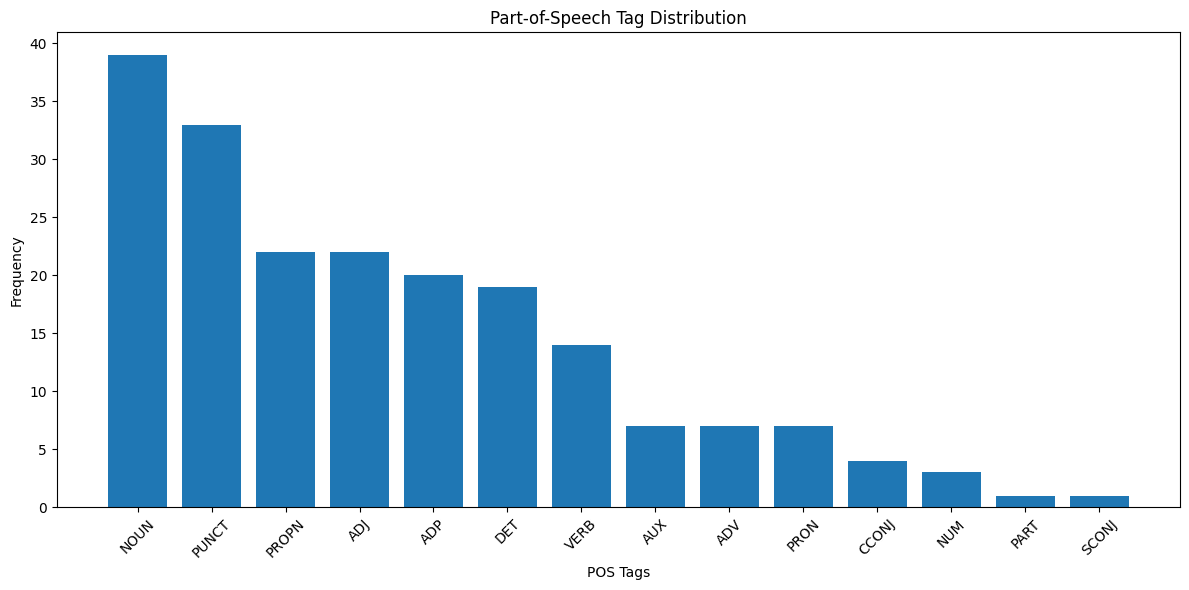

In [15]:
def pos_tagging(text, nlp_model):
    doc = nlp_model(text)
    pos_tokens = []
    
    for token in doc:
        if not token.is_space:
            pos_tokens.append({
                'text': token.text,
                'pos': token.pos_,
                'tag': token.tag_,
                'pos_description': spacy.explain(token.pos_),
                'tag_description': spacy.explain(token.tag_)
            })
    
    return pos_tokens

pos_tokens = pos_tagging(abstract, nlp)

print("POS Tagging Results:")
print("=" * 22)
print(f"Total tokens: {len(pos_tokens)}\n")

pos_df = pd.DataFrame(pos_tokens[:15])
print("First 15 tokens with POS tags:")
print(pos_df[['text', 'pos', 'pos_description']].to_string(index=False))

pos_counts = Counter([token['pos'] for token in pos_tokens])
print(f"\nPOS Tag Distribution:")
for pos, count in pos_counts.most_common():
    description = spacy.explain(pos) or pos
    print(f"{pos} ({description}): {count}")

plt.figure(figsize=(12, 6))
pos_labels, pos_counts_values = zip(*pos_counts.most_common())
plt.bar(pos_labels, pos_counts_values)
plt.title('Part-of-Speech Tag Distribution')
plt.xlabel('POS Tags')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 7. Phrase Chunking

In [16]:
def phrase_chunking(text, nlp_model):
    doc = nlp_model(text)
    
    noun_phrases = []
    for chunk in doc.noun_chunks:
        noun_phrases.append({
            'text': chunk.text,
            'root': chunk.root.text,
            'root_dep': chunk.root.dep_,
            'root_head': chunk.root.head.text
        })
    
    verb_phrases = []
    for token in doc:
        if token.pos_ == 'VERB':
            phrase_tokens = [token.text]
            for child in token.children:
                if child.dep_ in ['dobj', 'iobj', 'attr', 'prep']:
                    phrase_tokens.append(child.text)
            
            if len(phrase_tokens) > 1:
                verb_phrases.append({
                    'text': ' '.join(phrase_tokens),
                    'root_verb': token.text,
                    'dependencies': [child.dep_ for child in token.children]
                })
    
    return {
        'noun_phrases': noun_phrases,
        'verb_phrases': verb_phrases
    }

phrases = phrase_chunking(abstract, nlp)

print("Phrase Chunking Results:")
print("=" * 26)

print(f"Found {len(phrases['noun_phrases'])} noun phrases:")
if phrases['noun_phrases']:
    np_df = pd.DataFrame(phrases['noun_phrases'])
    print(np_df[['text', 'root', 'root_dep']].to_string(index=False))

print(f"\nFound {len(phrases['verb_phrases'])} verb phrases:")
if phrases['verb_phrases']:
    vp_df = pd.DataFrame(phrases['verb_phrases'])
    print(vp_df[['text', 'root_verb']].to_string(index=False))

np_roots = [np['root'] for np in phrases['noun_phrases']]
common_np_roots = Counter(np_roots).most_common(5)

print(f"\nMost common noun phrase roots:")
for root, count in common_np_roots:
    print(f"{root}: {count}")

Phrase Chunking Results:
Found 44 noun phrases:
                                              text            root root_dep
                         Recurrent Neural Networks        Networks    nsubj
                                              RNNs            RNNs    appos
                         the dominant architecture    architecture     attr
                                          sequence        sequence     pobj
                                              RNNs            RNNs    nsubj
                                 sequential models          models     attr
                                              that            that    nsubj
                                   parallelization parallelization     dobj
                                their computations    computations     pobj
                                      Transformers    Transformers    nsubj
                             a natural alternative     alternative     pobj
                                     sta

# 8. Syntactic Parser

In [18]:
def syntactic_parsing(text, nlp_model):
    doc = nlp_model(text)
    
    dependencies = []
    for token in doc:
        if not token.is_space:
            dependencies.append({
                'text': token.text,
                'dep': token.dep_,
                'dep_description': spacy.explain(token.dep_),
                'head': token.head.text,
                'pos': token.pos_,
                'children': [child.text for child in token.children]
            })
    
    sentence_structures = []
    for sent in doc.sents:
        root = [token for token in sent if token.dep_ == 'ROOT'][0]
        
        structure = {
            'sentence': sent.text.strip(),
            'root': root.text,
            'root_pos': root.pos_,
            'subjects': [token.text for token in sent if token.dep_ in ['nsubj', 'nsubjpass']],
            'objects': [token.text for token in sent if token.dep_ in ['dobj', 'iobj', 'pobj']],
            'modifiers': [token.text for token in sent if token.dep_ in ['amod', 'advmod', 'nummod']]
        }
        sentence_structures.append(structure)
    
    return dependencies, sentence_structures

dependencies, sentence_structures = syntactic_parsing(abstract, nlp)

print("Syntactic Parsing Results:")
print("=" * 28)

print("Dependency relationships (first 15 tokens):")
dep_df = pd.DataFrame(dependencies[:15])
print(dep_df[['text', 'dep', 'head', 'pos']].to_string(index=False))

dep_counts = Counter([dep['dep'] for dep in dependencies])
print(f"\nMost common dependency labels:")
for dep_label, count in dep_counts.most_common(10):
    description = spacy.explain(dep_label) or dep_label
    print(f"{dep_label} ({description}): {count}")

print(f"\nSentence Structure Analysis:")
print("-" * 30)
for i, struct in enumerate(sentence_structures[:3], 1):
    print(f"\nSentence {i}: {struct['sentence'][:80]}...")
    print(f"Root: {struct['root']} ({struct['root_pos']})")
    print(f"Subjects: {', '.join(struct['subjects']) if struct['subjects'] else 'None'}")
    print(f"Objects: {', '.join(struct['objects']) if struct['objects'] else 'None'}")
    print(f"Modifiers: {', '.join(struct['modifiers'][:5]) if struct['modifiers'] else 'None'}")

Syntactic Parsing Results:
Dependency relationships (first 15 tokens):
        text      dep         head   pos
   Recurrent compound     Networks PROPN
      Neural compound     Networks PROPN
    Networks    nsubj         been PROPN
           (    punct     Networks PUNCT
        RNNs    appos     Networks PROPN
           )    punct     Networks PUNCT
        have      aux         been   AUX
        long   advmod         been   ADV
        been     ROOT         been   AUX
         the      det architecture   DET
    dominant     amod architecture   ADJ
architecture     attr         been  NOUN
          in     prep architecture   ADP
    sequence     nmod     learning  NOUN
           -    punct     sequence PUNCT

Most common dependency labels:
punct (punctuation): 33
amod (adjectival modifier): 22
prep (prepositional modifier): 20
pobj (object of preposition): 20
det (determiner): 19
compound (compound): 15
nsubj (nominal subject): 12
dobj (direct object): 12
ROOT (root): 9
advmod